## Task 3: Robotic Scenario – Stereo Matching

Objective: Apply feature matching to stereo video feeds.



In [4]:
import os, re, time
import cv2
import numpy as np
import matplotlib.pyplot as plt

[AKAZE + F-RANSAC] FPS=24.4 | ⟨Ntotal⟩=338.6 | ⟨Ntent⟩=82.8 | ⟨Ninliers⟩=19.1 | inliers/tentatives=0.23 | inliers/total=0.06 | zero-inlier frames=0/240


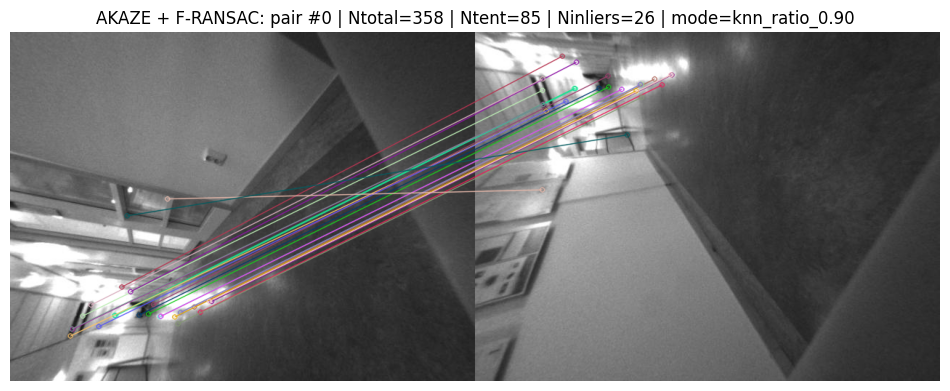

In [5]:
# Load data
def list_custom_pairs(root):
    ldir, rdir = os.path.join(root, "left"), os.path.join(root, "right")
    rexL = re.compile(r"left(\d+)\.(jpg|png)$", re.I)
    rexR = re.compile(r"right(\d+)\.(jpg|png)$", re.I)
    idxL = {int(rexL.search(f).group(1)): os.path.join(ldir, f) for f in os.listdir(ldir) if rexL.search(f)}
    idxR = {int(rexR.search(f).group(1)): os.path.join(rdir, f) for f in os.listdir(rdir) if rexR.search(f)}
    common = sorted(set(idxL) & set(idxR))
    return [(idxL[i], idxR[i]) for i in common]

# Detectors/Descriptors 

def make_akaze():
    # AKAZE uses binary MLDB descriptors (Hamming). Often steadier than ORB indoors.
    return cv2.AKAZE_create()  # default is good; keeps runtime reasonable

def clahe_gray(img):
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
    return clahe.apply(img)

# Matching utils

def get_tentatives(desL, desR, norm, min_needed=20):
    """
    Try progressively easier strategies to ensure we get some tentatives:
    (A) KNN + Lowe ratio 0.90, then 0.95, then 0.99
    (B) BF crossCheck=True
    Returns (matches, mode_str)
    """
    if desL is None or desR is None or len(desL)==0 or len(desR)==0:
        return [], "no_desc"

    # KNN + ratio (progressively relaxed)
    bf = cv2.BFMatcher(norm, crossCheck=False)
    for ratio in (0.90, 0.95, 0.99):
        knn = bf.knnMatch(desL, desR, k=2)
        tent = [m for (m, n) in knn if n is not None and m.distance < ratio * n.distance]
        if len(tent) >= min_needed:
            return tent, f"knn_ratio_{ratio:.2f}"

    # Cross-check 1-NN
    bf_cc = cv2.BFMatcher(norm, crossCheck=True)
    cc = bf_cc.match(desL, desR)
    return cc, "crosscheck"

def f_ransac_inliers(kpL, kpR, matches, thresh=2.0, conf=0.99):
    """Fundamental-matrix RANSAC → inlier subset."""
    if len(matches) < 8:
        return [], None
    ptsL = np.float32([kpL[m.queryIdx].pt  for m in matches])
    ptsR = np.float32([kpR[m.trainIdx].pt for m in matches])
    F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_RANSAC,
                                     ransacReprojThreshold=thresh, confidence=conf)
    if mask is None:
        return [], F
    keep = mask.ravel().astype(bool)
    return [m for m, k in zip(matches, keep) if k], F

# Runner

def run_stereo_sequence(
    root="datasets/custom_dataset",
    visualize_index=0,
    max_draw=140,
    min_needed_for_F=12
):
    pairs = list_custom_pairs(root)
    if not pairs:
        raise RuntimeError(f"No pairs found in {root}")

    det = make_akaze()              # primary choice for this indoor set
    norm = cv2.NORM_HAMMING         # AKAZE (MLDB) → Hamming

    frames = 0
    sum_total = sum_tent = sum_inl = 0
    zero_inlier_frames = 0
    tsum = 0.0

    vis_img, vis_title = None, ""

    for idx, (lp, rp) in enumerate(pairs):
        L = cv2.imread(lp, cv2.IMREAD_GRAYSCALE)
        R = cv2.imread(rp, cv2.IMREAD_GRAYSCALE)
        if L is None or R is None:
            continue

        # Light local-contrast boost helps in bland corridors
        Lc, Rc = clahe_gray(L), clahe_gray(R)

        t0 = time.time()
        kpL, desL = det.detectAndCompute(Lc, None)
        kpR, desR = det.detectAndCompute(Rc, None)
        Ntotal = len(kpL)

        tent, mode = get_tentatives(desL, desR, norm, min_needed=min_needed_for_F)
        inliers, F = f_ransac_inliers(kpL, kpR, tent, thresh=2.0, conf=0.99)
        Ninl = len(inliers)

        tsum += time.time() - t0
        frames += 1
        sum_total += Ntotal
        sum_tent  += len(tent)
        sum_inl   += Ninl
        if Ninl == 0:
            zero_inlier_frames += 1

        if idx == visualize_index:
            if Ninl > 0:
                draw = sorted(inliers, key=lambda m: m.distance)[:max_draw]
                tag = f"inliers (F-RANSAC, {mode})"
            elif len(tent) > 0:
                draw = sorted(tent, key=lambda m: m.distance)[:max_draw]
                tag = f"tentatives ({mode})"
            else:
                # as a last resort draw nothing-found message (but this should be rare now)
                draw = []
                tag = "no matches"
            vis_img = cv2.drawMatches(L, kpL, R, kpR, draw, None,
                                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
            vis_title = (f"AKAZE + F-RANSAC: pair #{idx} | "
                         f"Ntotal={Ntotal} | Ntent={len(tent)} | Ninliers={Ninl} "
                         f"| mode={mode}")

    fps = frames / max(tsum, 1e-6)
    avg_total = sum_total / max(frames, 1)
    avg_tent  = sum_tent  / max(frames, 1)
    avg_inl   = sum_inl   / max(frames, 1)
    print(f"[AKAZE + F-RANSAC] FPS={fps:.1f} | ⟨Ntotal⟩={avg_total:.1f} | "
          f"⟨Ntent⟩={avg_tent:.1f} | ⟨Ninliers⟩={avg_inl:.1f} | "
          f"inliers/tentatives={(avg_inl/max(avg_tent,1e-6)):.2f} | "
          f"inliers/total={(avg_inl/max(avg_total,1e-6)):.2f} | "
          f"zero-inlier frames={zero_inlier_frames}/{frames}")

    if vis_img is not None:
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        plt.title(vis_title)
        plt.axis("off")
        plt.show()

if __name__ == "__main__":
    run_stereo_sequence(
        root="datasets/custom_dataset",
        visualize_index=0,     # any pair index to inspect
        max_draw=140,
        min_needed_for_F=12
    )


[PennCOSYVIO | AKAZE + F-RANSAC] FPS=20.3 | ⟨Ntotal⟩=1160.2 | ⟨Ntent⟩=849.5 | ⟨Ninliers⟩=688.5 | ⟨Nfailed⟩=471.6 | inliers/tentatives=0.81 | inliers/total=0.59 | zero-inlier frames=0/131


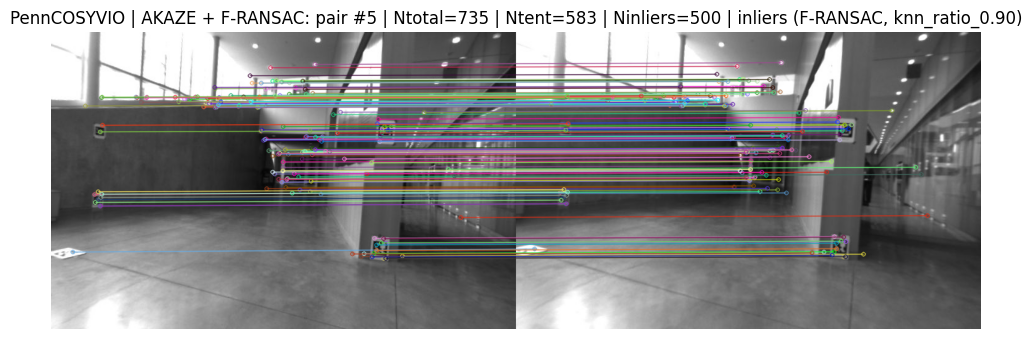

Summary: {'fps': 20.25679382218725, 'avg_Ntotal': 1160.1526717557251, 'avg_Ntent': 849.5419847328244, 'avg_Ninliers': 688.5343511450382, 'avg_Nfailed': 471.61832061068696, 'ratio_inliers_over_tent': 0.8104771318177734, 'ratio_inliers_over_total': 0.5934859849980261, 'zero_inlier_frames': 0, 'total_frames': 131}


In [6]:
# Load data

def list_penncosyvio_pairs(root):
    """
    root = 'datasets/PennCOSYVIO_dataset'
      root/left_cam_frames/frame_XXXX.png
      root/right_cam_frames/frame_XXXX.png
    Returns sorted [(left_path, right_path)] for common indices.
    """
    ldir = os.path.join(root, "left_cam_frames")
    rdir = os.path.join(root, "right_cam_frames")
    rex  = re.compile(r"frame_(\d+)\.(png|jpg|jpeg)$", re.I)

    idxL = {int(rex.search(f).group(1)): os.path.join(ldir, f)
            for f in os.listdir(ldir) if rex.search(f)}
    idxR = {int(rex.search(f).group(1)): os.path.join(rdir, f)
            for f in os.listdir(rdir) if rex.search(f)}

    common = sorted(set(idxL) & set(idxR))
    return [(idxL[i], idxR[i]) for i in common]

# Detectors/Descriptors

def make_akaze():
    # AKAZE (MLDB, binary) is robust for indoor/handheld; still reasonably fast on CPU
    # Can tune threshold to get more/fewer points; smaller -> more points
    return cv2.AKAZE_create()  # cv2.AKAZE_create(threshold=8e-4)

def clahe_gray(img):
    # Light local contrast boost; safe for indoor sequences
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
    return clahe.apply(img)

# Matching utils

def get_tentatives(desL, desR, norm, min_needed=20):
    """
    Progressive matching:
      (A) KNN + Lowe ratio at 0.90, then 0.95, then 0.99
      (B) If still few, fall back to BF crossCheck=True (symmetric 1-NN)
    Returns (matches, mode_str)
    """
    if desL is None or desR is None or len(desL)==0 or len(desR)==0:
        return [], "no_desc"

    # KNN + Lowe ratio
    bf = cv2.BFMatcher(norm, crossCheck=False)
    for ratio in (0.90, 0.95, 0.99):
        knn = bf.knnMatch(desL, desR, k=2)
        tent = [m for (m, n) in knn if n is not None and m.distance < ratio * n.distance]
        if len(tent) >= min_needed:
            return tent, f"knn_ratio_{ratio:.2f}"

    # Cross-checked 1-NN (guarantees some lines)
    bf_cc = cv2.BFMatcher(norm, crossCheck=True)
    cc = bf_cc.match(desL, desR)
    return cc, "crosscheck"

def f_ransac_inliers(kpL, kpR, matches, thresh=2.0, conf=0.99):
    """Fundamental-matrix RANSAC on unrectified stereo -> inlier subset."""
    if len(matches) < 8:
        return [], None
    ptsL = np.float32([kpL[m.queryIdx].pt  for m in matches])
    ptsR = np.float32([kpR[m.trainIdx].pt for m in matches])
    F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_RANSAC,
                                     ransacReprojThreshold=thresh, confidence=conf)
    if mask is None:
        return [], F
    keep = mask.ravel().astype(bool)
    inliers = [m for m, k in zip(matches, keep) if k]
    return inliers, F

# Runner

def run_penncosyvio(
    root="datasets/PennCOSYVIO_dataset",
    visualize_index=0,
    max_draw=140,
    min_needed_for_F=12,
    ransac_thresh=2.0,
    confidence=0.99,
    downscale=1.0  # e.g., 0.75 for more FPS
):
    pairs = list_penncosyvio_pairs(root)
    if not pairs:
        raise RuntimeError(f"No pairs found in {root}")

    det = make_akaze()
    norm = cv2.NORM_HAMMING  # AKAZE(MLDB) -> Hamming

    frames = 0
    sum_total = sum_tent = sum_inl = 0
    zero_inlier_frames = 0
    tsum = 0.0
    vis_img, vis_title = None, ""

    for idx, (lp, rp) in enumerate(pairs):
        L = cv2.imread(lp, cv2.IMREAD_GRAYSCALE)
        R = cv2.imread(rp, cv2.IMREAD_GRAYSCALE)
        if L is None or R is None:
            continue

        if downscale != 1.0:
            L = cv2.resize(L, None, fx=downscale, fy=downscale, interpolation=cv2.INTER_AREA)
            R = cv2.resize(R, None, fx=downscale, fy=downscale, interpolation=cv2.INTER_AREA)

        # Mild contrast boost
        Lc, Rc = clahe_gray(L), clahe_gray(R)

        t0 = time.time()
        kpL, desL = det.detectAndCompute(Lc, None)
        kpR, desR = det.detectAndCompute(Rc, None)
        Ntotal = len(kpL)

        tent, mode = get_tentatives(desL, desR, norm, min_needed=min_needed_for_F)
        inliers, F = f_ransac_inliers(kpL, kpR, tent, thresh=ransac_thresh, conf=confidence)
        Ninl = len(inliers)

        tsum += time.time() - t0
        frames += 1
        sum_total += Ntotal
        sum_tent  += len(tent)
        sum_inl   += Ninl
        if Ninl == 0:
            zero_inlier_frames += 1

        if idx == visualize_index:
            if Ninl > 0:
                draw = sorted(inliers, key=lambda m: m.distance)[:max_draw]
                tag = f"inliers (F-RANSAC, {mode})"
            elif len(tent) > 0:
                draw = sorted(tent, key=lambda m: m.distance)[:max_draw]
                tag = f"tentatives ({mode})"
            else:
                draw = []
                tag = "no matches"
            vis_img = cv2.drawMatches(L, kpL, R, kpR, draw, None,
                                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
            vis_title = (f"PennCOSYVIO | AKAZE + F-RANSAC: pair #{idx} | "
                         f"Ntotal={Ntotal} | Ntent={len(tent)} | Ninliers={Ninl} | {tag}")

    fps = frames / max(tsum, 1e-6)
    avg_total = sum_total / max(frames, 1)
    avg_tent  = sum_tent  / max(frames, 1)
    avg_inl   = sum_inl   / max(frames, 1)
    avg_failed = avg_total - avg_inl

    print(f"[PennCOSYVIO | AKAZE + F-RANSAC] FPS={fps:.1f} | "
          f"⟨Ntotal⟩={avg_total:.1f} | ⟨Ntent⟩={avg_tent:.1f} | "
          f"⟨Ninliers⟩={avg_inl:.1f} | ⟨Nfailed⟩={avg_failed:.1f} | "
          f"inliers/tentatives={(avg_inl/max(avg_tent,1e-6)):.2f} | "
          f"inliers/total={(avg_inl/max(avg_total,1e-6)):.2f} | "
          f"zero-inlier frames={zero_inlier_frames}/{frames}")

    if vis_img is not None:
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        plt.title(vis_title)
        plt.axis("off")
        plt.show()

    return {
        "fps": fps,
        "avg_Ntotal": avg_total,
        "avg_Ntent": avg_tent,
        "avg_Ninliers": avg_inl,
        "avg_Nfailed": avg_failed,
        "ratio_inliers_over_tent": avg_inl / max(avg_tent, 1e-6),
        "ratio_inliers_over_total": avg_inl / max(avg_total, 1e-6),
        "zero_inlier_frames": zero_inlier_frames,
        "total_frames": frames
    }

# Main

if __name__ == "__main__":
    stats = run_penncosyvio(
        root="datasets/PennCOSYVIO_dataset",
        visualize_index=5,    # any list index to draw
        max_draw=160,
        min_needed_for_F=12,
        ransac_thresh=2.0,
        confidence=0.99,
        downscale=1.0         # set to 0.75 for more FPS
    )
    print("Summary:", stats)
